In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# from torchviz import make_dot

import torch
import torch.nn as nn
from torch.optim import Adam
import os
import argparse
import time
from tqdm import tqdm
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Old code, no modular classes

In [ ]:
# def double_conv(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, 3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_channels, out_channels, 3, padding=1),
#         nn.ReLU(inplace=True)
#     )
    
# class Loupe(nn.Module):
#     def __init__(self, image_dims, pmask_slope, sample_slope, sparsity, device, eps=0.01):
#         super(Loupe, self).__init__()
#         self.image_dims = image_dims
#         self.pmask_slope = pmask_slope
#         self.sample_slope = sample_slope
#         self.sparsity = sparsity
#         self.device = device

#         # UNet
#         self.dconv_down1 = double_conv(2, 64)
#         self.dconv_down2 = double_conv(64, 128)
#         self.dconv_down3 = double_conv(128, 256)
#         self.dconv_down4 = double_conv(256, 512)        

#         self.maxpool = nn.MaxPool2d(2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
#         self.dconv_up3 = double_conv(256 + 512, 256)
#         self.dconv_up2 = double_conv(128 + 256, 128)
#         self.dconv_up1 = double_conv(128 + 64, 64)
        
#         self.conv_last = nn.Conv2d(64, 1, 1)

#         # Mask
#         self.pmask = nn.Parameter(torch.FloatTensor(*self.image_dims, 2)) # Mask is same dimension as image plus complex domain
#         self.pmask.requires_grad = True
#         self.pmask.data.uniform_(eps, 1-eps)
#         self.pmask.data = -torch.log(1. / self.pmask.data - 1.) / self.pmask_slope
#         self.pmask.data = self.pmask.data.to(self.device)

#     def complex_abs(self, x):
#         # Tensor should be of shape (N, l, w, 2)
#         x = torch.sqrt(x[:,:,:,0]**2 + x[:,:,:,1]**2).unsqueeze(3)
#         return x

#     def sparsify(self, mask):
#         xbar = mask.mean()
#         r = self.sparsity / xbar
#         beta = (1-self.sparsity) / (1-xbar)
#         le = (r <= 1).float()
#         return le * mask * r + (1-le) * (1 - (1 - mask) * beta) 

#     def threshold(self, mask):
#         random_uniform = torch.empty(*self.image_dims, 2).uniform_(0, 1).to(self.device)
#         return torch.sigmoid(self.sample_slope*(mask - random_uniform))

#     def undersample(self, x, prob_mask):
#         mask = prob_mask.expand(x.shape[0], -1, -1, -1)
#         undersampled_x = torch.zeros(x.size())
#         undersampled_x[:,:,:,0] = torch.mul(x[:,:,:,0], mask[:,:,:,0])
#         undersampled_x[:,:,:,1] = torch.mul(x[:,:,:,1], mask[:,:,:,0])
#         return undersampled_x
        
#     def unet(self, x):
#         conv1 = self.dconv_down1(x)
#         x = self.maxpool(conv1)

#         conv2 = self.dconv_down2(x)
#         x = self.maxpool(conv2)
        
#         conv3 = self.dconv_down3(x)
#         x = self.maxpool(conv3)   
        
#         x = self.dconv_down4(x)
        
#         x = self.upsample(x)        
#         x = torch.cat([x, conv3], dim=1)
        
#         x = self.dconv_up3(x)
#         x = self.upsample(x)        
#         x = torch.cat([x, conv2], dim=1)       

#         x = self.dconv_up2(x)
#         x = self.upsample(x)        
#         x = torch.cat([x, conv1], dim=1)   
        
#         x = self.dconv_up1(x)
        
#         x = self.conv_last(x)
#         return x
        
        
#     def forward(self, x):
#         # FFT into k-space
#         x = x.view(-1, *self.image_dims, 1)
#         x = torch.cat((x, torch.zeros(x.shape).to(self.device)), dim=3)

#         # FFT into k space
#         x = torch.fft(x, signal_ndim=2)

#         # Apply probabilistic mask
#         probmask = torch.sigmoid(self.pmask_slope*self.pmask)
        
#         # Sparsify
#         sparse_mask = self.sparsify(probmask)
        
#         # Threshold
#         mask = self.threshold(sparse_mask)
        
#         # Undersample
#         x = self.undersample(x, mask)

#         # iFFT into image space
#         x = torch.ifft(x, signal_ndim=2).to(self.device)
#         abs_tensor = self.complex_abs(x)

#         # Through unet
#         x = x.view(-1, 2, *self.image_dims) # Reshape for convolution
#         x = self.unet(x)
#         unet_tensor = x.view(-1, *self.image_dims, 1) # Reshape for convolution

#         out = unet_tensor + abs_tensor

#         return out 

# model = Loupe((160, 224), pmask_slope=5, sample_slope=12, sparsity=0.05, device='cpu')
# model.load_state_dict(torch.load('./model.119.h5',map_location='cpu'))
# model = model.to('cpu')

# for name, param in model.named_parameters():
#     print(name, param.size())

# y = model(torch.zeros(1, 160, 224, 1).to('cpu'))
# make_dot(y, params=dict(model.named_parameters()))

# New code, with modular classes

In [14]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        # UNet
        self.dconv_down1 = self.double_conv(2, 64)
        self.dconv_down2 = self.double_conv(64, 128)
        self.dconv_down3 = self.double_conv(128, 256)
        self.dconv_down4 = self.double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = self.double_conv(256 + 512, 256)
        self.dconv_up2 = self.double_conv(128 + 256, 128)
        self.dconv_up1 = self.double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, 1)
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        x = self.conv_last(x)
        return x
    
class Mask(nn.Module):
    def __init__(self, image_dims, pmask_slope, sample_slope, sparsity, device, eps=0.01):
        super(Mask, self).__init__()
        
        self.image_dims = image_dims
        self.pmask_slope = pmask_slope
        self.sample_slope = sample_slope
        self.device = device
        self.sparsity = sparsity
        
        # Mask
        self.pmask = nn.Parameter(torch.FloatTensor(*self.image_dims)) # Mask is same dimension as image plus complex domain
        self.pmask.requires_grad = True
        self.pmask.data.uniform_(eps, 1-eps)
        self.pmask.data = -torch.log(1. / self.pmask.data - 1.) / self.pmask_slope
        self.pmask.data = self.pmask.data.to(self.device)
        
    def squash_mask(self, mask):
        return torch.sigmoid(self.pmask_slope*mask)
    
    def sparsify(self, mask):
        xbar = mask.mean()
        r = self.sparsity / xbar
        beta = (1-self.sparsity) / (1-xbar)
        le = (r <= 1).float()
        return le * mask * r + (1-le) * (1 - (1 - mask) * beta) 

    def threshold(self, mask):
        random_uniform = torch.empty(*self.image_dims).uniform_(0, 1).to(self.device)
        return torch.sigmoid(self.sample_slope*(mask - random_uniform))
    
    def forward(self, x):
        # Apply probabilistic mask
        probmask = self.squash_mask(self.pmask)
        # Sparsify
        sparse_mask = self.sparsify(probmask)
        # Threshold
        mask = self.threshold(sparse_mask)
        return mask
    
class Loupe(nn.Module):
    def __init__(self, image_dims, pmask_slope, sample_slope, sparsity, device):
        super(Loupe, self).__init__()
        self.image_dims = image_dims
        self.pmask_slope = pmask_slope
        self.sample_slope = sample_slope
        self.sparsity = sparsity
        self.device = device

        # Unet
        self.unet = Unet()

        # Mask
        self.mask = Mask(image_dims, pmask_slope, sample_slope, sparsity, device)
        

    def complex_abs(self, x):
        # Tensor should be of shape (N, l, w, 2)
        x = torch.sqrt(x[:,:,:,0]**2 + x[:,:,:,1]**2).unsqueeze(3)
        return x

    def undersample(self, x, prob_mask):
        mask = prob_mask.expand_as(x)
        undersampled_x = torch.zeros(x.size())
        # for i in range(x.shape[0]):
        #     undersampled_x[i,:,:,0] = torch.mul(x[i,:,:,0], prob_mask[:,:,0])
        #     undersampled_x[i,:,:,1] = torch.mul(x[i,:,:,1], prob_mask[:,:,0])
        undersampled_x[:,:,:,0] = torch.mul(x[:,:,:,0], mask[:,:,:,0])
        undersampled_x[:,:,:,1] = torch.mul(x[:,:,:,1], mask[:,:,:,0])
        return undersampled_x
            
    def forward(self, x, epoch=0, tot_epochs=0, mode='relax'):
        assert x.shape[-1] == 2, 'Data must have complex dimension'

        # FFT into k space
        x = torch.fft(x, signal_ndim=2)

        mask = self.mask(x)
        
        # Threshold
        assert mode in ['ste-identity', 'ste-sigmoid', 'relax'], 'mode should be ste_identity, ste_sigmoid, relax'
        # if mode == 'ste-identity':
        #     stidentity = straight_through_sample.STIdentity.apply
        #     mask = stidentity(sparse_mask)
        # elif mode == 'ste-sigmoid':
        #     stsigmoid = straight_through_sample.STSigmoid.apply
        #     mask = stsigmoid(sparse_mask, epoch, tot_epochs)
        # else:
            # mask = self.threshold(sparse_mask)
        
        # Undersample
        x = self.undersample(x, mask)

        # iFFT into image space
        x = torch.ifft(x, signal_ndim=2).to(self.device)
        abs_tensor = self.complex_abs(x)

        # Through unet
        x = x.view(-1, 2, self.image_dims[0], self.image_dims[1]) # Reshape for convolution
        x = self.unet(x)
        unet_tensor = x.view(-1, self.image_dims[0], self.image_dims[1], 1) # Reshape for convolution

        out = unet_tensor + abs_tensor
        out = torch.cat((out, out), dim=3)

        return out

# model = Loupe((160, 224), pmask_slope=5, sample_slope=12, sparsity=0.05, device='cpu')
# # model.load_state_dict(torch.load('./model.119.h5',map_location='cpu'))
# model = model.to('cpu')

# for name, param in model.named_parameters():
#     print(name, param.size())

# y = model(torch.zeros(1, 160, 224, 1).to('cpu'))
# make_dot(y, params=dict(model.named_parameters()))

In [15]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs, batch_size, device, filename, mode, load_checkpoint):
    # best_model_wts = copy.deepcopy(model.state_dict())
    # best_loss = 1e10
    # mask = None
    loss = 0
    loss_list = []
    val_loss_list = []
    sample_mask = None
    for epoch in range(load_checkpoint, load_checkpoint+num_epochs):
        for phase in ['train']: #, 'val']:
            if phase == 'train':
                print('TRAIN EPOCH ' + str(epoch))
                model.train()
            else:
                print('VALIDATE EPOCH ' + str(epoch))
                model.eval()

            # metrics = defaultdict(float)
            # metrics['loss'] = 0
            # epoch_samples = 0

            for batch_idx, (x, _) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):   
                x = x.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    output, sample_mask = model(x)
                    print(output.shape, x.shape)
                    loss = criterion(output, x)

                    # metrics['loss'] += loss.data.cpu().numpy() * x.size(0)

                    if phase == 'train':
                        if batch_idx == 0:
                            loss_list.append(loss)
                        loss.backward()
                        optimizer.step()
                    else:
                        if batch_idx == 0:
                            val_loss_list.append(loss)

                # statistics
                # epoch_samples += x.size(0)

            # epoch_loss = metrics['loss'] / epoch_samples

        torch.save(model.state_dict(), filename.format(epoch=epoch))
        plt.imshow(sample_mask[..., 0].cpu().detach().numpy())
        plt.show()

    # print('Best val loss: {:4f}'.format(best_loss))
    
    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, loss_list, val_loss_list



In [11]:
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [4]:
gpu_id = 0
filename_prefix = 'jupyter-default'
mode = 'relax'
loss = 'mae'
pmask_slope = 1
sample_slope = 100
desired_sparsity = 0.25
lr = 0.001
image_dims = (320, 320, 2)

models_dir = '../models'
batch_size = 4
workers = 8

data_path = '/nfs02/data/processed_nyu/NYU_training_Biograph.npy'
load_checkpoint = 0
nb_epochs_train = 100
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpu_id))
else:
    device = torch.device('cpu')

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

# prepare save sub-folder
local_name = '{prefix}_{mode}_{loss}_{pmask_slope}_{sample_slope}_{sparsity}_{lr}'.format(
    prefix=filename_prefix,
    mode=mode,
    loss=loss,
    pmask_slope=pmask_slope,
    sample_slope=sample_slope,
    sparsity=desired_sparsity,
    lr=lr)
save_dir_loupe = os.path.join(models_dir, local_name)
if not os.path.isdir(save_dir_loupe): os.makedirs(save_dir_loupe)
filename = os.path.join(save_dir_loupe, 'model.{epoch:02d}.h5')
print('model filenames: %s' % filename)

# Data loading
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': workers}

print('loading data...')
xdata = np.load(data_path)
trainset = Dataset(xdata[:int(len(xdata)*0.7)], xdata[:int(len(xdata)*0.7)])
valset = Dataset(xdata[int(len(xdata)*0.7):], xdata[int(len(xdata)*0.7):])
dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, **params),
    'val': torch.utils.data.DataLoader(valset, **params)
}
print('done')

if xdata.shape[-1] == 1:
    print('appending complex dimension into dataset')
    x = torch.cat((x, torch.zeros(x.shape).to(self.device)), dim=3)

image_dims = xdata.shape[1:]

model = Loupe(image_dims, pmask_slope=pmask_slope, sample_slope=sample_slope, sparsity=desired_sparsity, device=device)
model = model.to(device)
# Load checkpoint
if load_checkpoint != 0:
    print('LOADING FROM ' + filename)
    model.load_state_dict(torch.load(filename.format(epoch=load_checkpoint-1)))

assert loss in ['mae', 'mse'], 'loss must be mae or mse'
if loss == 'mae':
    criterion = nn.L1Loss()
else:
    criterion = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

model, train_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, nb_epochs_train, batch_size, device, filename, mode, load_checkpoint)

model filenames: ../models/jupyter-default_relax_mae_1_100_0.25_0.001/model.{epoch:02d}.h5
loading data...
done
TRAIN EPOCH 0



  0%|          | 1/667 [00:00<03:05,  3.60it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  0%|          | 2/667 [00:00<02:45,  4.03it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  1%|          | 4/667 [00:00<02:24,  4.58it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  1%|          | 6/667 [00:01<02:15,  4.89it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  1%|          | 8/667 [00:01<02:09,  5.07it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  1%|▏         | 10/667 [00:01<02:03,  5.32it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  2%|▏         | 12/667 [00:02<02:01,  5.40it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  2%|▏         | 14/667 [00:02<02:03,  5.28it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  2%|▏         | 15/667 [00:02<02:05,  5.19it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  3%|▎         | 17/667 [00:03<02:00,  5.38it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])



  3%|▎         | 19/667 [00:03<02:03,  5.23it/s]

torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])
torch.Size([4, 320, 320, 1])
torch.Size([4, 320, 320, 1]) torch.Size([4, 320, 320, 2])


KeyboardInterrupt: 

LOADING FROM /home/aw847/cond_loupe/models/baseline-cond-experiments_relax_mae_1.0_100.0_0.25_0.001/model.299.h5


/nfs01/shared_software/anaconda3/envs/zhilu37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


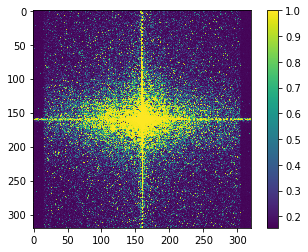

In [16]:
model = Loupe(image_dims, pmask_slope=pmask_slope, sample_slope=sample_slope, sparsity=desired_sparsity, device=device)
model = model.to(device)
# Load checkpoint
filename = '/home/aw847/cond_loupe/models/baseline-cond-experiments_relax_mae_1.0_100.0_0.25_0.001/model.299.h5'
print('LOADING FROM ' + filename)
model.load_state_dict(torch.load(filename.format(epoch=load_checkpoint-1)))
mask = model.state_dict()['mask.pmask']
mask = model.mask.squash_mask(torch.tensor(mask))
mask = model.mask.sparsify(mask)
mask = mask.detach().cpu().numpy().squeeze()[..., 0]
mask = np.fft.fftshift(mask)
plt.imshow(mask)
plt.colorbar()
plt.show()